# Time Series Forecasting of Currency Exchange

A short demo showcasing forecasting using a Temporal Fusion Transformer model (TFT).

In [ ]:
import torch
from datetime import datetime, timedelta

from src.data_pp import fetch_data, preprocess_data, create_dataloaders, create_datasets, visualize_timeseries_data
from src.network import build_model, train_model, make_predictions, visualize_predictions

### Data preparations

The data is gathered from the open API frankfurter.dev, and has historical data for currency exchange dating back many years, and gets updated every day. This program only extracts data from the last year, and then only looks at the last 90 days out of that, but please feel free to fool around with the parameters below.

The extracted JSON data is processed to remove empty values, give weekday names, set target currency, sort dates and so on. When that is done it becomes a dataset using the pytorch-forecasting class `TimeSeriesDataset` which sort the data further into a prepared state with targets, known and unknown categoricals, as well as some target normalizations. This is in turn divided into training sets and validation sets.

In [2]:
if torch.cuda.is_available():
    print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Running on CPU.")

start_date = "2024-01-01"
end_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")

print(f"Fetching exchange rate data from {start_date} to {end_date}...")
df = fetch_data(start_date, end_date)

print(f"Data shape: {df.shape}")
print("Sample data:")
print(df.head())

target_currency = "USD"
print(f"Preprocessing data for {target_currency}...")
processed_df = preprocess_data(df, target_currency=target_currency)

max_prediction_length = 30  # Forecast horizon (30 days)
max_encoder_length = 90  # Look-back window (90 days)

print("Creating time series datasets...")
training, validation = create_datasets(
    processed_df,
    max_prediction_length=max_prediction_length,
    max_encoder_length=max_encoder_length
)

print("Creating dataloaders...")
train_dataloader, val_dataloader = create_dataloaders(training, validation)

print("Dataloaders created.")

CUDA is available! Using GPU: NVIDIA GeForce RTX 2070 SUPER
Fetching exchange rate data from 2024-01-01 to 2025-04-15...
Data shape: (9930, 3)
Sample data:
        date currency    rate
0 2023-12-29      AUD  1.6263
1 2023-12-29      BGN  1.9558
2 2023-12-29      BRL  5.3618
3 2023-12-29      CAD  1.4642
4 2023-12-29      CHF  0.9260
Preprocessing data for USD...
Creating time series datasets...
Creating dataloaders...
Dataloaders created.


### Data visualization

See below tables and graphs for an understanding of what the data looks like.

Dataset contains 302 time steps

Sample data (first 10 rows):
   Time Index  Exchange Rate  Weekday  Month
0          12         1.0946        2      0
1          13         1.0987        3      0
2          14         1.0942        4      0
3          17         1.0945        0      0
4          18         1.0882        1      0
5          19         1.0877        2      0
6          20         1.0875        3      0
7          21         1.0887        4      0
8          24         1.0890        0      0
9          25         1.0872        1      0

Summary statistics for Exchange Rate:
count    302.000000
mean       1.075835
std        0.022334
min        1.019800
25%        1.059150
50%        1.081500
75%        1.089150
max        1.119600
Name: Exchange Rate, dtype: float64


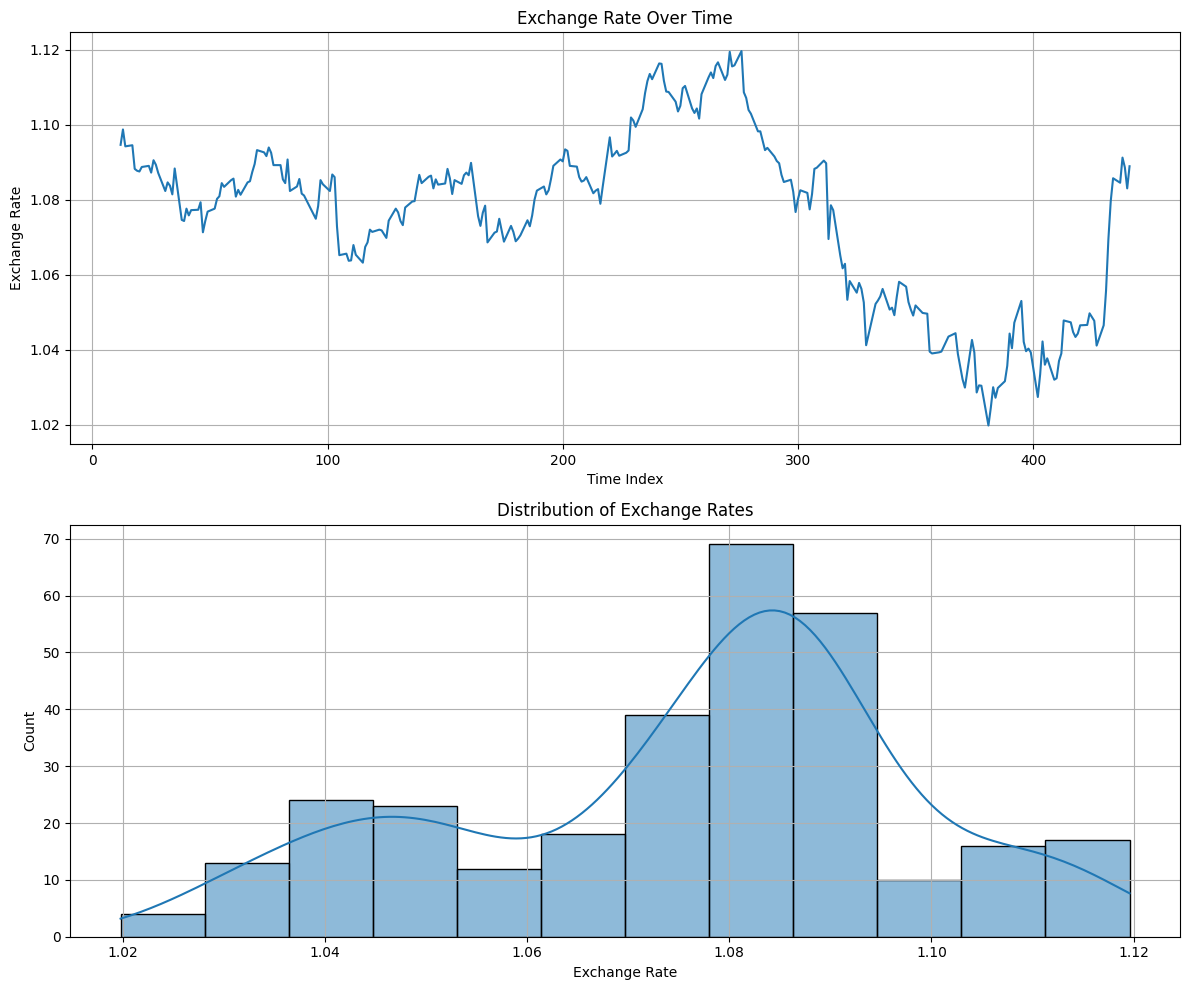

In [3]:
df = visualize_timeseries_data(train_dataloader.dataset.data)

### Model and training

Please see the below output to see model structure. The training is set to a maximum of 30 epochs, but is found to more often than not stop (early stopping) at around 15-20, with a validation loss of around 0.023. 

In [4]:
print("Building Temporal Fusion Transformer model...")
model = build_model(training)

print("Training model...")
trainer = train_model(model, train_dataloader, val_dataloader)

c:\KODA\TimeSeriesForecastingDemo\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\KODA\TimeSeriesForecastingDemo\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Building Temporal Fusion Transformer model...
Training model...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 92     | train
3  | prescalers                         | ModuleDict                      | 416    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 21.4 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\KODA\TimeSeriesForecastingDemo\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Predictions

The below graph shows what the model predicts what the exchange rate to be, including some quantile options for different probabilities.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Making predictions...
Transposed predictions to correct dimensions
Visualizing predictions...
Raw predictions shape: torch.Size([72, 7, 30])
Sample prediction values (first 3 days):
Quantile 0: [1.0724843 1.0739152 1.0739354]
Quantile 1: [1.078486  1.0797236 1.0795842]
Quantile 2: [1.0803826 1.0814896 1.0814149]
Quantile 3: [1.0829775 1.0837014 1.0834875]
Quantile 4: [1.0866698 1.0869668 1.0866752]
Quantile 5: [1.0906829 1.0906767 1.0903254]
Quantile 6: [1.0918043 1.0913515 1.0909051]
Error in visualization: too many indices for tensor of dimension 3


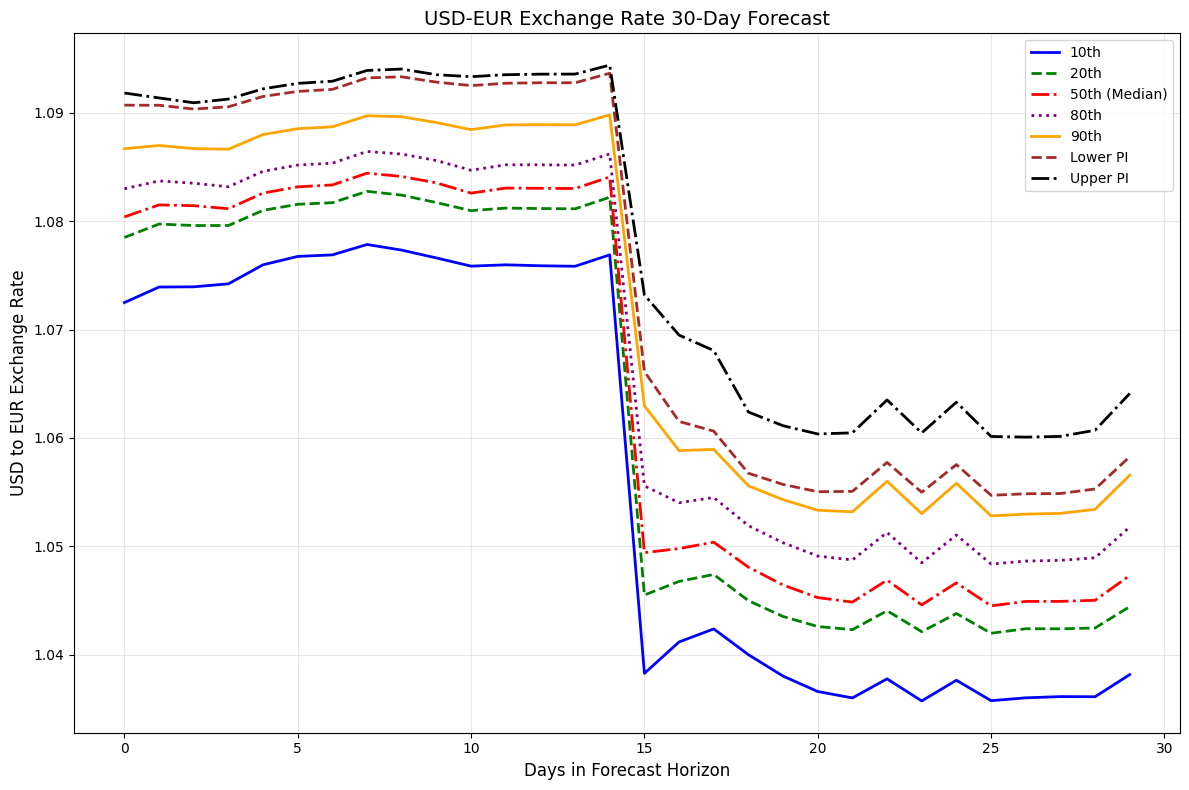

In [5]:

print("Making predictions...")
raw_predictions, x, y, _, _ = make_predictions(model, val_dataloader)

print("Visualizing predictions...")
visualize_predictions(model, raw_predictions, x)
